In [125]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.optim as optim
from nn_base_models import FeedforwardNN


The structure of this section will be as so. I will consider 3 classes of IVP problem: \
\
• $y' = -y, y(0)=1$. This has the solution $y = e^{-x}$\
• $y' = y^2, y(0) = 1$. This has the solution $y=\frac{1}{1-x}$\
• $y' = \cos x, y(0) = 0$. This has the solution $y = \sin x$


The structure will be as follows. For each of these classes of subproblem, I will first see how 3 models each with different activation functions performs on these problems, varying number of hidden layers and number of neurons per hidden layer. Each of those results will be scaled and then we can see how varying the learning rate affects the solutions too. For the first case I'll see how the function fits to the region, and then examine how they fit outside the region too. 

For the second case, we will examine how they deal with a singularity. Likely extremely poorly. Similar approach though, and we shall see how they perform.
Third case, we will examine how they deal with a periodic function.

In [ ]:
# Here we define the relevant functions to train the IVP for this first problem

def compute_derivative(y, x):
    dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return dy_dx

# Loss function for the ODE and initial condition
def loss_function(model, x_collocation, x_ic, y_ic, gamma=100):
    x_collocation = x_collocation.requires_grad_(True)
    y_pred = model(x_collocation)
    dy_dx = compute_derivative(y_pred, x_collocation)

    # Residual: dy/dx + y ≈ 0
    ode_residual = dy_dx + y_pred
    loss_ode = torch.mean(ode_residual**2)

    # Initial condition loss
    y_ic_pred = model(x_ic)
    loss_ic = torch.mean((y_ic_pred - y_ic)**2)

    return loss_ode + gamma*loss_ic, loss_ode.item(), loss_ic.item()

# Training loop
def train_ivp(model, epochs=2000, lr=1e-3, n_collocation=100, domain=(0.0, 1.0), verbose=True, gamma=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    x_collocation = torch.linspace(domain[0], domain[1], n_collocation).view(-1, 1)
    x_collocation = x_collocation.requires_grad_(True)

    # Initial condition remains at x = 0
    x_ic = torch.tensor([[domain[0]]], requires_grad=True)
    y_ic = torch.tensor([[1.0]])

    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_ode, loss_ic = loss_function(model, x_collocation, x_ic, y_ic, gamma)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch}: Total Loss = {loss.item():.6f}, ODE = {loss_ode:.6f}, IC = {loss_ic:.6f}")
        loss_history.append(loss.item())

    return loss_history

    


Epoch 0: Total Loss = 52.889828, ODE = 0.082066, IC = 1.056155
Epoch 100: Total Loss = 0.109706, ODE = 0.101471, IC = 0.000165
Epoch 200: Total Loss = 0.029608, ODE = 0.029575, IC = 0.000001
Epoch 300: Total Loss = 0.019499, ODE = 0.019482, IC = 0.000000
Epoch 400: Total Loss = 0.014018, ODE = 0.014008, IC = 0.000000
Epoch 500: Total Loss = 0.010353, ODE = 0.010347, IC = 0.000000
Epoch 600: Total Loss = 0.007962, ODE = 0.007958, IC = 0.000000
Epoch 700: Total Loss = 0.006378, ODE = 0.006376, IC = 0.000000
Epoch 800: Total Loss = 0.005273, ODE = 0.005271, IC = 0.000000
Epoch 900: Total Loss = 0.004444, ODE = 0.004443, IC = 0.000000
Epoch 1000: Total Loss = 0.003780, ODE = 0.003779, IC = 0.000000
Epoch 1100: Total Loss = 0.003226, ODE = 0.003225, IC = 0.000000
Epoch 1200: Total Loss = 0.002756, ODE = 0.002755, IC = 0.000000
Epoch 1300: Total Loss = 0.002356, ODE = 0.002355, IC = 0.000000
Epoch 1400: Total Loss = 0.002016, ODE = 0.002016, IC = 0.000000
Epoch 1500: Total Loss = 0.001729, O

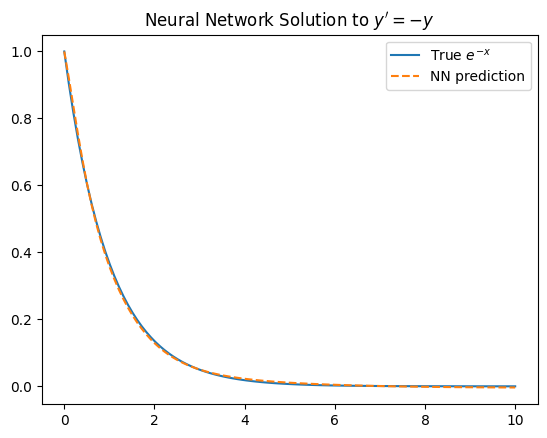

In [18]:
# sense_check above functions work
model = FeedforwardNN(input_dim=1, output_dim=1, hidden_layers=2, hidden_units=20, activation='tanh')

# Train
loss_history = train_ivp(model, epochs=2000, lr=1e-3, gamma=50, domain=(0.0, 10.0))

# Plot prediction vs true
x_test = torch.linspace(0, 10, 100).view(-1, 1)
with torch.no_grad():
    y_pred = model(x_test)
y_true = torch.exp(-x_test)

plt.plot(x_test, y_true, label='True $e^{-x}$')
plt.plot(x_test, y_pred, '--', label='NN prediction')
plt.legend()
plt.title("Neural Network Solution to $y' = -y$")
plt.show()

In [51]:
# Now I will evaluate the best structure for fitting to this simple structure.
activations = ['tanh', 'relu']
layer_counts = [i for i in range(1, 11)]
widths = [i for i in range(1, 21)]

# Tracking results
results = []

# Loop through configurations
for act in activations:
    for layers in layer_counts:
        for width in widths:
            config = {
                "activation": act,
                "hidden_layers": layers,
                "hidden_units": width
            }
            print(f"Training model: {config}")
            model = FeedforwardNN(input_dim=1, output_dim=1,
                                  hidden_layers=layers,
                                  hidden_units=width,
                                  activation=act)
            
            start = time.time()
            train_ivp(model, epochs=2500, lr=1e-2, verbose=False)  # you can adjust epochs/lr

            # Evaluate MSE on training domain
            x_eval = torch.linspace(0, 1, 100).view(-1, 1)
            y_true = torch.exp(-x_eval)
            with torch.no_grad():
                y_pred = model(x_eval)
                mse = torch.mean((y_pred - y_true)**2).item()
            duration = time.time() - start

            # Store results
            results.append({
                "activation": act,
                "layers": layers,
                "width": width,
                "mse": mse,
                "train_time_sec": duration
            })


Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 1}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 2}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 3}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 4}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 5}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 6}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 7}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 8}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 9}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 10}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 11}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 12}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'h

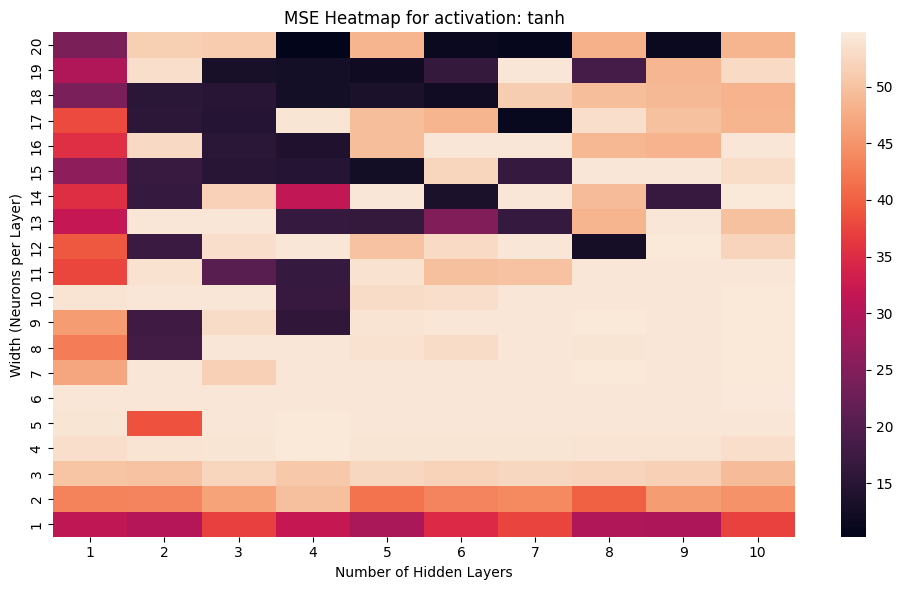

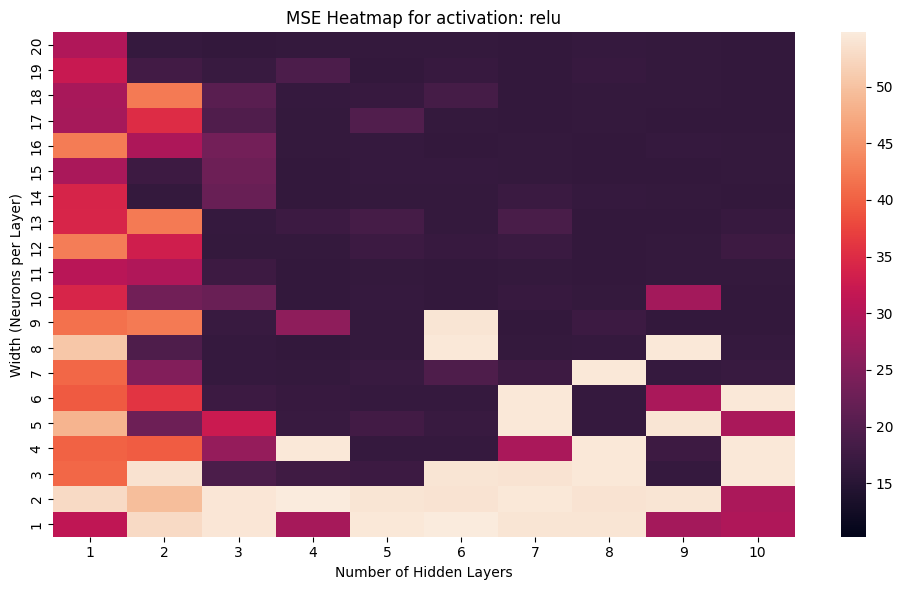

In [129]:
results_df = pd.DataFrame(results)

#Ensure heatmaps are scaled similarly
global_min = results_df["mse"].min()
global_max = results_df["mse"].max()
log_norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

for act in results_df['activation'].unique():
    df_subset = results_df[results_df['activation'] == act]

    # Pivot to get a grid: rows = width, columns = layers, values = mse
    plt.figure(figsize=(10, 6))
    heatmap_data = df_subset.pivot(index="width", columns="layers", values="mse")
    sns.heatmap(heatmap_data, cmap="rocket", norm=log_norm)
    
    plt.gca().invert_yaxis()
    plt.title(f"MSE Heatmap for activation: {act}")
    plt.xlabel("Number of Hidden Layers")
    plt.ylabel("Width (Neurons per Layer)")
    plt.tight_layout()
    plt.savefig(f"report/graphics/mse_heatmap_{act}.png", dpi=300)
    plt.show()

6 15 tanh


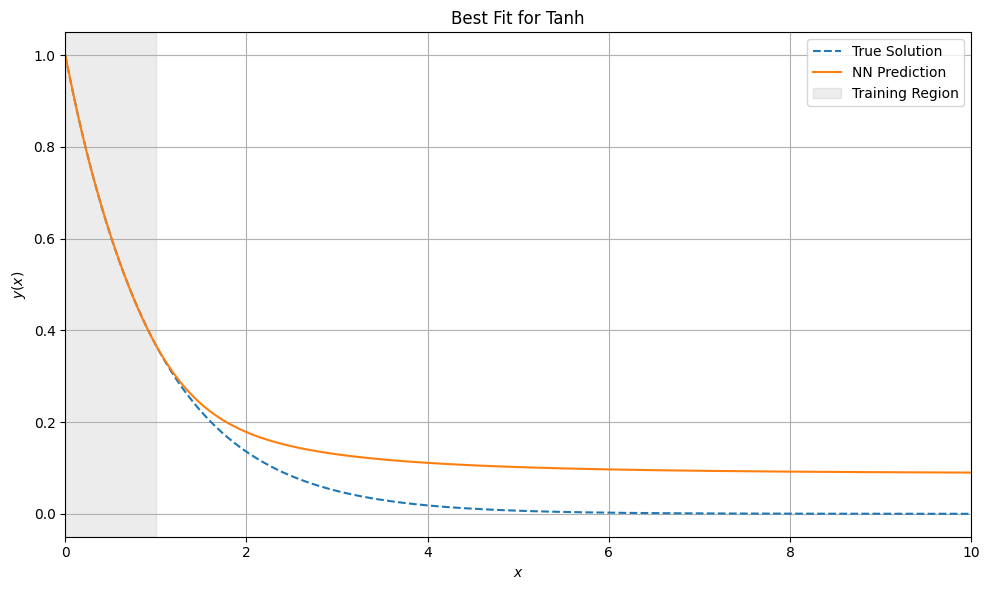

7 14 relu


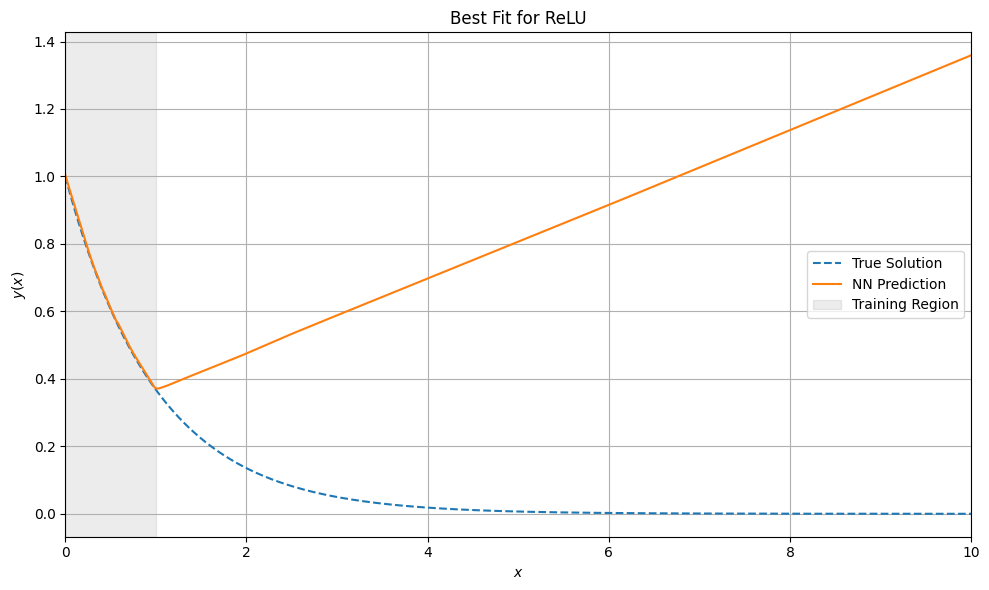

8 1 tanh


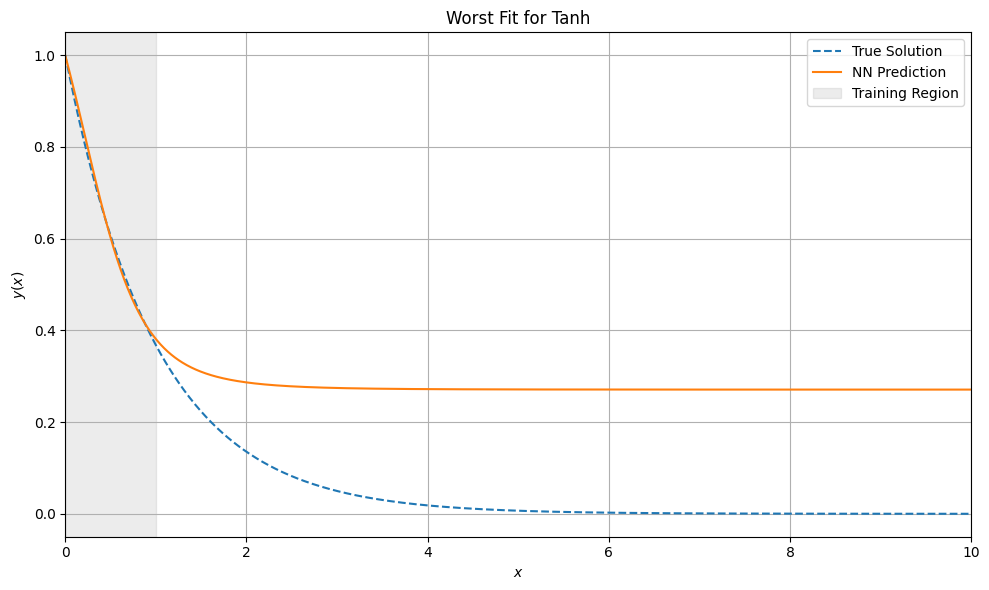

7 8 relu


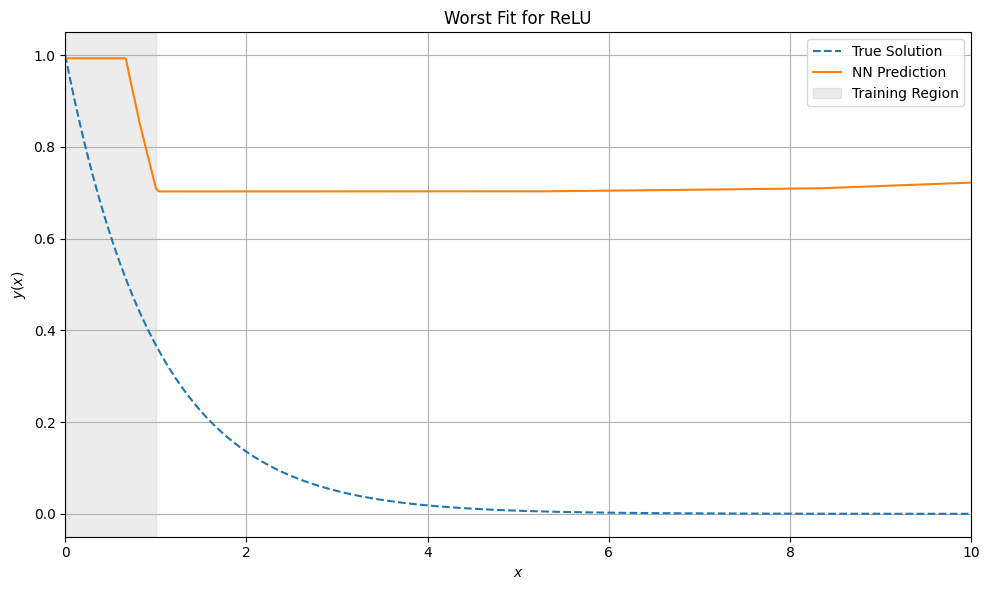

In [67]:
best_configs = {}
worst_configs = {}

for act in results_df['activation'].unique():
    df_sub = results_df[results_df['activation'] == act]
    best_row = df_sub.loc[df_sub['mse'].idxmin()]
    worst_row = df_sub.loc[df_sub['mse'].idxmax()]
    best_configs[act] = best_row
    worst_configs[act] = worst_row


def plot_fit(config, title, save_prefix="fit_plot"):
    layers = int(config['layers'])
    width = int(config['width'])
    act = config['activation']
    print(layers, width, act)
    model = FeedforwardNN(input_dim=1, output_dim=1,
                          hidden_layers=layers,
                          hidden_units=width,
                          activation=act)
    train_ivp(model, epochs=2000, lr=1e-2, verbose=False)

    x_test = torch.linspace(0, 10, 1000).view(-1, 1)
    y_true_vals = torch.exp(-x_test)

    with torch.no_grad():
        y_pred = model(x_test)

    plt.figure(figsize=(10, 6))
    plt.plot(x_test.numpy(), y_true_vals.numpy(), "--", label="True Solution")
    plt.plot(x_test.numpy(), y_pred.numpy(), label="NN Prediction")
    plt.axvspan(0, 1, color="gray", alpha=0.15, label="Training Region")

    plt.title(title)
    plt.xlabel("$x$")
    plt.ylabel("$y(x)$")
    plt.xlim([0, 10])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save with informative filename
    filename = f"report/graphics/{save_prefix}_{act}_{layers}layers_{width}width.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")

    plt.show()



plot_fit(best_configs["tanh"], "Best Fit for Tanh", save_prefix="best_fit")
plot_fit(best_configs["relu"], "Best Fit for ReLU", save_prefix="best_fit")
plot_fit(worst_configs["tanh"], "Worst Fit for Tanh", save_prefix="worst_fit")
plot_fit(worst_configs["relu"], "Worst Fit for ReLU", save_prefix="worst_fit")


Epoch 0: Total Loss = 1.004717, ODE = 0.501565, IC = 0.005032
Epoch 100: Total Loss = 0.417596, ODE = 0.417577, IC = 0.000000
Epoch 200: Total Loss = 0.352061, ODE = 0.352061, IC = 0.000000
Epoch 300: Total Loss = 0.284824, ODE = 0.284823, IC = 0.000000
Epoch 400: Total Loss = 0.214280, ODE = 0.214279, IC = 0.000000
Epoch 500: Total Loss = 0.189513, ODE = 0.189337, IC = 0.000002
Epoch 600: Total Loss = 0.174599, ODE = 0.174556, IC = 0.000000
Epoch 700: Total Loss = 0.160861, ODE = 0.160838, IC = 0.000000
Epoch 800: Total Loss = 0.145922, ODE = 0.145849, IC = 0.000001
Epoch 900: Total Loss = 0.128606, ODE = 0.128135, IC = 0.000005
Epoch 1000: Total Loss = 0.108210, ODE = 0.108210, IC = 0.000000
Epoch 1100: Total Loss = 0.086221, ODE = 0.086220, IC = 0.000000
Epoch 1200: Total Loss = 0.066177, ODE = 0.065781, IC = 0.000004
Epoch 1300: Total Loss = 0.049376, ODE = 0.049090, IC = 0.000003
Epoch 1400: Total Loss = 0.038512, ODE = 0.038512, IC = 0.000000
Epoch 1500: Total Loss = 0.029227, OD

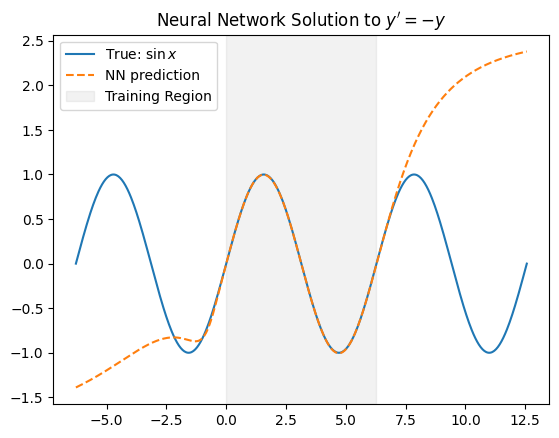

In [132]:
# Now I need to run the same analysis as earlier, but for the problem that contains a singularity. 
#  The problem now is: $y' = y^2, y(0) = 1$. This has the solution $y=\frac{1}{1-x}$.

def compute_derivative(y, x):
    dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return dy_dx

def loss_function(model, x_collocation, x_ic, y_ic, gamma=100):
    x_collocation = x_collocation.requires_grad_(True)
    y_pred = model(x_collocation)
    dy_dx = compute_derivative(y_pred, x_collocation)

    # Residual: dy/dx - cos(x)
    ode_residual = dy_dx - torch.cos(x_collocation)
    loss_ode = torch.mean(ode_residual**2)

    y_ic_pred = model(x_ic)
    loss_ic = torch.mean((y_ic_pred - y_ic)**2)

    return loss_ode + gamma * loss_ic, loss_ode.item(), loss_ic.item()

# Training loop
def train_ivp(model, epochs=2000, lr=1e-3, n_collocation=100, domain=(0.0, 0.99), verbose=True, gamma=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    x_collocation = torch.linspace(domain[0], domain[1], n_collocation).view(-1, 1)
    x_collocation = x_collocation.requires_grad_(True)

    # Initial condition remains at x = 0
    x_ic = torch.tensor([[domain[0]]], requires_grad=True)
    y_ic = torch.tensor([[0]])

    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_ode, loss_ic = loss_function(model, x_collocation, x_ic, y_ic, gamma)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch}: Total Loss = {loss.item():.6f}, ODE = {loss_ode:.6f}, IC = {loss_ic:.6f}")
        loss_history.append(loss.item())

    return loss_history

# sense check everythign above is setup correctly
model = FeedforwardNN(input_dim=1, output_dim=1, hidden_layers=3, hidden_units=18, activation='tanh')
train_ivp(model, epochs=10000, verbose=True, domain=(0.0, 2*np.pi))

x_test = torch.linspace(-2*np.pi, 4*np.pi, 500).view(-1, 1)
with torch.no_grad():
    y_pred = model(x_test)
y_true = torch.sin(x_test)

plt.plot(x_test.numpy(), y_true.numpy(), label='True: $\\sin x$')
plt.plot(x_test, y_pred, '--', label='NN prediction')
plt.axvspan(0, 2*np.pi, color='gray', alpha=0.1, label='Training Region')
plt.legend()
plt.title("Neural Network Solution to $y' = -y$")
plt.show()
    


In [88]:
# Ok we are ready to go. Let's now conduct the same big analysis and generate all these charts

# Now I will evaluate the best structure for fitting to this simple structure.
activations = ['tanh', 'relu']
layer_counts = [i for i in range(1, 11)]
widths = [i for i in range(1, 21)]

# Tracking results
results = []

# Loop through configurations
for act in activations:
    for layers in layer_counts:
        for width in widths:
            config = {
                "activation": act,
                "hidden_layers": layers,
                "hidden_units": width
            }
            print(f"Training model: {config}")
            model = FeedforwardNN(input_dim=1, output_dim=1,
                                  hidden_layers=layers,
                                  hidden_units=width,
                                  activation=act)
            
            start = time.time()
            train_ivp(model, epochs=2500, verbose=False, domain=(0.0, 2*np.pi))

            # Evaluate MSE on training domain
            x_eval = torch.linspace(0, 2*np.pi, 100).view(-1, 1)
            y_true = torch.sin(x_eval)
            with torch.no_grad():
                y_pred = model(x_eval)
                mse = torch.mean((y_pred - y_true)**2).item()
            duration = time.time() - start

            # Store results
            results.append({
                "activation": act,
                "layers": layers,
                "width": width,
                "mse": mse,
                "train_time_sec": duration
            })


Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 1}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 2}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 3}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 4}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 5}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 6}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 7}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 8}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 9}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 10}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 11}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 12}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'h

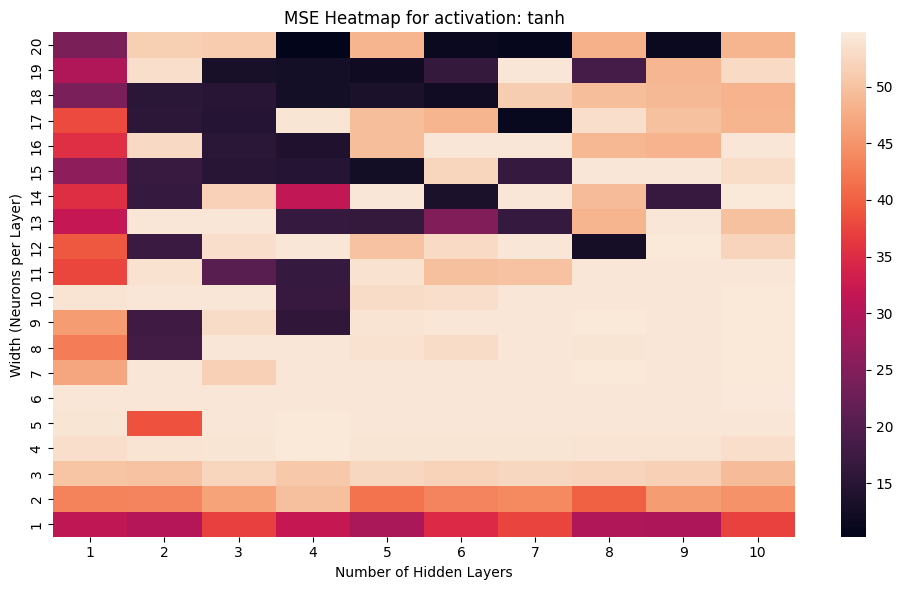

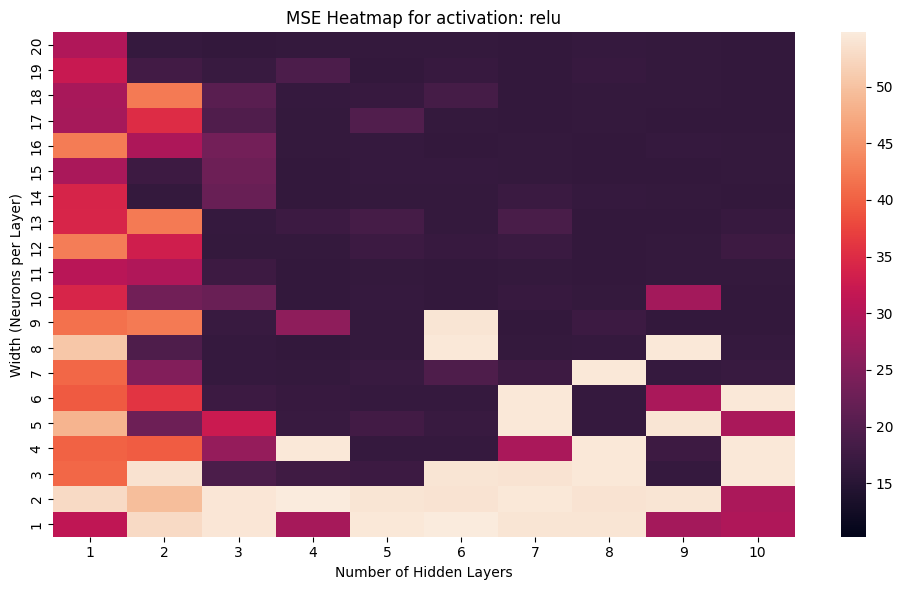

In [130]:
# Ensure the heatmaps use the same scale
global_min = results_df["mse"].min()
global_max = results_df["mse"].max()
log_norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

results_df = pd.DataFrame(results)
for act in results_df['activation'].unique():
    df_subset = results_df[results_df['activation'] == act]

    plt.figure(figsize=(10, 6))
    heatmap_data = df_subset.pivot(index="width", columns="layers", values="mse")
    sns.heatmap(heatmap_data, cmap="rocket", norm=log_norm)
    plt.gca().invert_yaxis()
    plt.title(f"MSE Heatmap for activation: {act}")
    plt.xlabel("Number of Hidden Layers")
    plt.ylabel("Width (Neurons per Layer)")
    plt.tight_layout()
    plt.savefig(f"report/graphics/mse_heatmap_ivp_periodic_{act}.png", dpi=300)
    plt.show()

In [131]:
best_configs = {}
worst_configs = {}

for act in results_df['activation'].unique():
    df_sub = results_df[results_df['activation'] == act]
    best_row = df_sub.loc[df_sub['mse'].idxmin()]
    worst_row = df_sub.loc[df_sub['mse'].idxmax()]
    best_configs[act] = best_row
    worst_configs[act] = worst_row


def plot_fit(config, title, save_prefix="fit_plot"):
    layers = int(config['layers'])
    width = int(config['width'])
    act = config['activation']
    print(layers, width, act)
    model = FeedforwardNN(input_dim=1, output_dim=1,
                          hidden_layers=layers,
                          hidden_units=width,
                          activation=act)
    train_ivp(model, epochs=20000, verbose=False, domain=(-4*np.pi, 4*np.pi))

    x_test = torch.linspace(-10*np.pi, 10*np.pi, 5000).view(-1, 1)
    y_true_vals = torch.sin(x_test)

    with torch.no_grad():
        y_pred = model(x_test)

    plt.figure(figsize=(10, 6))
    plt.plot(x_test.numpy(), y_true_vals.numpy(), "--", label="True Solution")
    plt.plot(x_test.numpy(), y_pred.numpy(), label="NN Prediction")
    plt.axvspan(-4*np.pi, 4*np.pi, color="gray", alpha=0.15, label="Training Region")

    plt.title(title)
    plt.xlabel("$x$")
    plt.ylabel("$y(x)$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save with informative filename
    filename = f"report/graphics/ivp_periodic_{save_prefix}_{act}_{layers}layers_{width}width.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")

    plt.show()



plot_fit(best_configs["tanh"], "Best Fit for Tanh", save_prefix="best_fit")
plot_fit(best_configs["relu"], "Best Fit for ReLU", save_prefix="best_fit")
plot_fit(worst_configs["tanh"], "Worst Fit for Tanh", save_prefix="worst_fit")
plot_fit(worst_configs["relu"], "Worst Fit for ReLU", save_prefix="worst_fit")


4 20 tanh


TypeError: train_ivp() missing 2 required positional arguments: 'y0' and 'x0'

Epoch 0: Total Loss = 37.870979
Epoch 500: Total Loss = 0.971231
Epoch 1000: Total Loss = 0.799775
Epoch 1500: Total Loss = 0.633857
Epoch 2000: Total Loss = 0.494730
Epoch 2500: Total Loss = 0.283403
Epoch 3000: Total Loss = 0.215053
Epoch 3500: Total Loss = 0.153856
Epoch 4000: Total Loss = 0.128475
Epoch 4500: Total Loss = 0.114476
Epoch 5000: Total Loss = 0.105532
Epoch 5500: Total Loss = 0.149251
Epoch 6000: Total Loss = 0.094341
Epoch 6500: Total Loss = 0.088374
Epoch 7000: Total Loss = 0.081958
Epoch 7500: Total Loss = 0.077206
Epoch 8000: Total Loss = 0.072706
Epoch 8500: Total Loss = 0.068454
Epoch 9000: Total Loss = 0.064650
Epoch 9500: Total Loss = 0.061321
Epoch 10000: Total Loss = 0.058402
Epoch 10500: Total Loss = 0.055807
Epoch 11000: Total Loss = 0.053386
Epoch 11500: Total Loss = 0.051101
Epoch 12000: Total Loss = 0.049379
Epoch 12500: Total Loss = 0.047066
Epoch 13000: Total Loss = 0.045128
Epoch 13500: Total Loss = 0.043506
Epoch 14000: Total Loss = 0.042020
Epoch 14

/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_60736/53411143.py:56: RuntimeWarning: divide by zero encountered in divide
  y_true = 1 / (1 - x_plot_np)


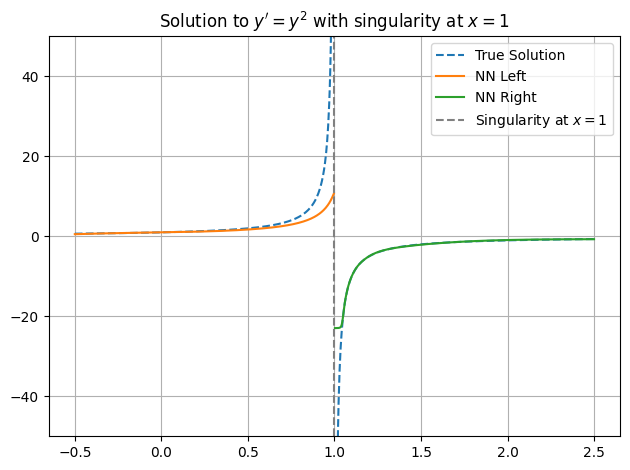

In [117]:
# Now I need to run the same analysis as earlier, but for the problem that contains a singularity. 
#  The problem now is: $y' = y^2, y(0) = 1$. This has the solution $y=\frac{1}{1-x}$.

def compute_derivative(y, x):
    dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return dy_dx

def loss_function(model, x_collocation, x_ic, y_ic, gamma=100):
    x_collocation = x_collocation.requires_grad_(True)
    y_pred = model(x_collocation)
    dy_dx = compute_derivative(y_pred, x_collocation)

    # Residual: dy/dx - cos(x)
    ode_residual = dy_dx - y_pred**2
    loss_ode = torch.mean(ode_residual**2)

    y_ic_pred = model(x_ic)
    loss_ic = torch.mean((y_ic_pred - y_ic)**2)

    return loss_ode + gamma * loss_ic, loss_ode.item(), loss_ic.item()

# Training loop
def train_ivp(model, y0, x0, domain, epochs=3000, lr=1e-3, n_collocation=100, verbose=True, gamma=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    x_collocation = torch.linspace(domain[0], domain[1], n_collocation).view(-1, 1)
    x_ic = torch.tensor([[x0]], dtype=torch.float32)
    y_ic = torch.tensor([[y0]], dtype=torch.float32)

    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_ode, loss_ic = loss_function(model, x_collocation, x_ic, y_ic, gamma)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch}: Total Loss = {loss.item():.6f}")
        loss_history.append(loss.item())

    return loss_history

# sense check everythign above is setup correctly
# Train on both sides

# Left side of singularity (0 < x < 1)
model_left = FeedforwardNN(1, 1, hidden_layers=3, hidden_units=20, activation='tanh')
train_ivp(model_left, y0=1.0, x0=0.0, domain=(0.0, 0.99), n_collocation=300, epochs=20000)

# Right side of singularity (x > 1), initial condition y(1.05) = 1 / (1 - 1.05) = -20
model_right = FeedforwardNN(1, 1, hidden_layers=3, hidden_units=20, activation='tanh')
train_ivp(model_right, y0=-20.0, x0=1.05, domain=(1.05, 2.0), n_collocation=300)

x_plot = torch.linspace(-0.5, 2.5, 1001).view(-1, 1)
x_plot_np = x_plot.numpy()
y_true = 1 / (1 - x_plot_np)

with torch.no_grad():
    y_left = model_left(x_plot[x_plot[:, 0] < 1])
    y_right = model_right(x_plot[x_plot[:, 0] > 1])

plt.plot(x_plot_np, y_true, '--', label='True Solution')
plt.plot(x_plot_np[x_plot_np[:, 0] < 1], y_left.numpy(), label='NN Left')
plt.plot(x_plot_np[x_plot_np[:, 0] > 1], y_right.numpy(), label='NN Right')
plt.axvline(1.0, color='gray', linestyle='--', label='Singularity at $x=1$')
plt.ylim((-50, 50))
plt.grid(True)
plt.legend()
plt.title("Solution to $y' = y^2$ with singularity at $x=1$")
plt.tight_layout()
plt.show()



In [118]:
activations = ['tanh', 'relu']
layer_counts = list(range(1, 11))
widths = list(range(1, 21))

results = []

for act in activations:
    for layers in layer_counts:
        for width in widths:
            config = {
                "activation": act,
                "hidden_layers": layers,
                "hidden_units": width
            }
            print(f"Training model: {config}")
            start = time.time()

            # --- Left model: train on [0, 0.95], with y(0) = 1
            model_left = FeedforwardNN(
                input_dim=1,
                output_dim=1,
                hidden_layers=layers,
                hidden_units=width,
                activation=act
            )
            train_ivp(model_left, y0=1.0, x0=0.0, domain=(0.0, 0.95), epochs=2500, verbose=False)

            # --- Right model: train on [1.05, 2.0], with y(1.05) = 1 / (1 - 1.05) = -20
            model_right = FeedforwardNN(
                input_dim=1,
                output_dim=1,
                hidden_layers=layers,
                hidden_units=width,
                activation=act
            )
            train_ivp(model_right, y0=-20.0, x0=1.05, domain=(1.05, 2.0), epochs=2500, verbose=False)

            # --- Evaluate on both sides
            x_eval_left = torch.linspace(0.0, 0.95, 100).view(-1, 1)
            x_eval_right = torch.linspace(1.05, 2.0, 100).view(-1, 1)
            y_true_left = 1 / (1 - x_eval_left)
            y_true_right = 1 / (1 - x_eval_right)

            with torch.no_grad():
                y_pred_left = model_left(x_eval_left)
                y_pred_right = model_right(x_eval_right)

            mse_left = torch.mean((y_pred_left - y_true_left)**2).item()
            mse_right = torch.mean((y_pred_right - y_true_right)**2).item()
            total_mse = mse_left + mse_right

            duration = time.time() - start

            results.append({
                "activation": act,
                "layers": layers,
                "width": width,
                "mse": total_mse,
                "mse_left": mse_left,
                "mse_right": mse_right,
                "train_time_sec": duration
            })


Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 1}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 2}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 3}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 4}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 5}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 6}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 7}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 8}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 9}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 10}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 11}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'hidden_units': 12}
Training model: {'activation': 'tanh', 'hidden_layers': 1, 'h

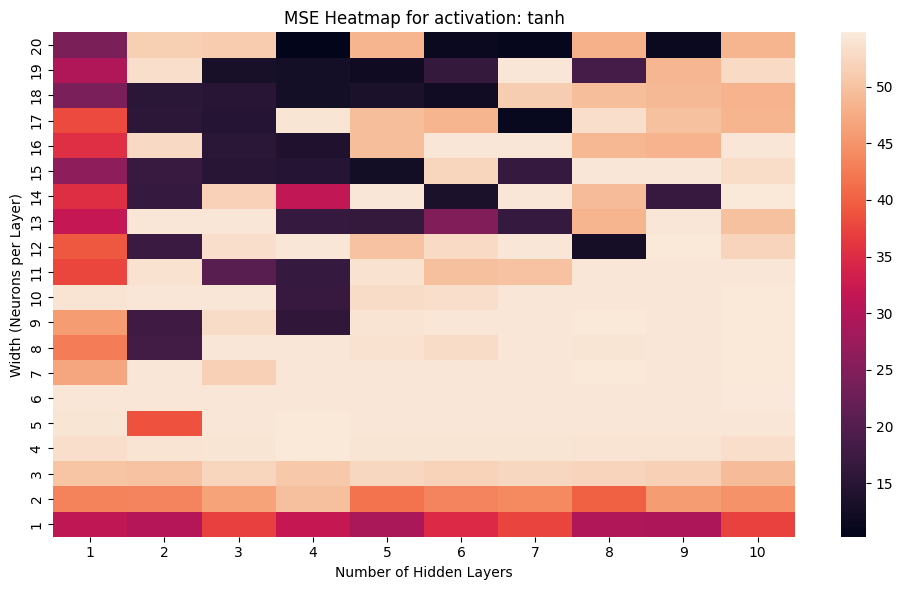

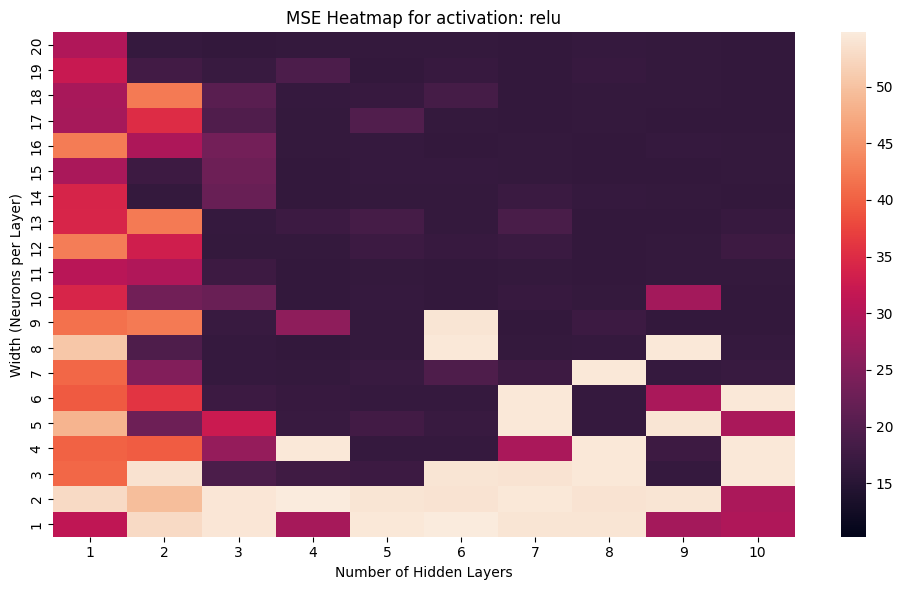

In [133]:
global_min = results_df["mse"].min()
global_max = results_df["mse"].max()
log_norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

for act in results_df['activation'].unique():
    df_subset = results_df[results_df['activation'] == act]

    plt.figure(figsize=(10, 6))
    heatmap_data = df_subset.pivot(index="width", columns="layers", values="mse")
    sns.heatmap(heatmap_data, cmap="rocket", norm=log_norm)

    plt.gca().invert_yaxis()
    plt.title(f"MSE Heatmap for activation: {act}")
    plt.xlabel("Number of Hidden Layers")
    plt.ylabel("Width (Neurons per Layer)")
    plt.tight_layout()
    plt.savefig(f"report/graphics/mse_heatmap_ivp_singularity_{act}.png", dpi=300)
    plt.show()

Plotting Best Fit for Tanh: 7 layers, 15 width, tanh activation


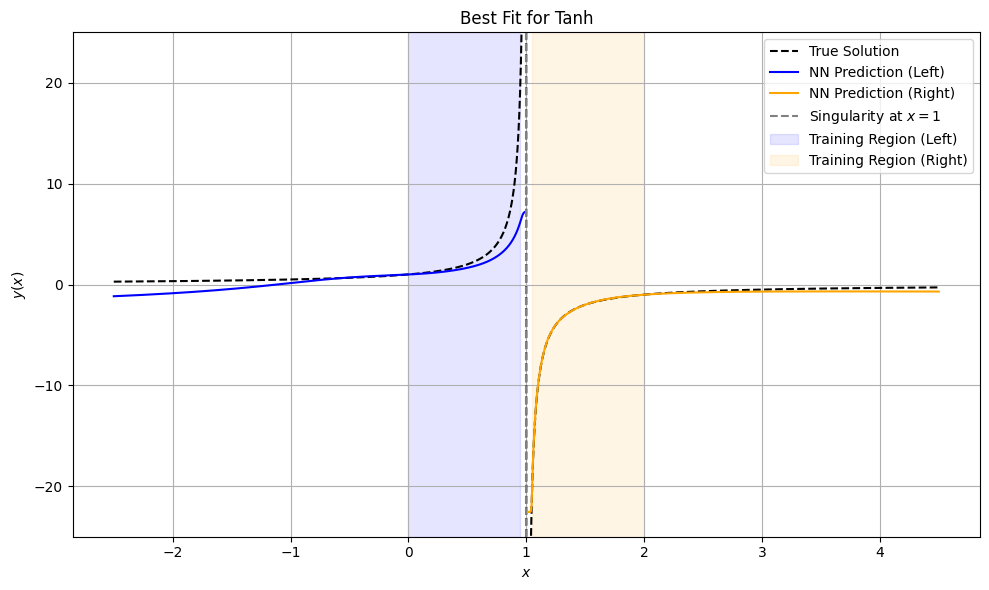

Plotting Best Fit for ReLU: 8 layers, 8 width, relu activation


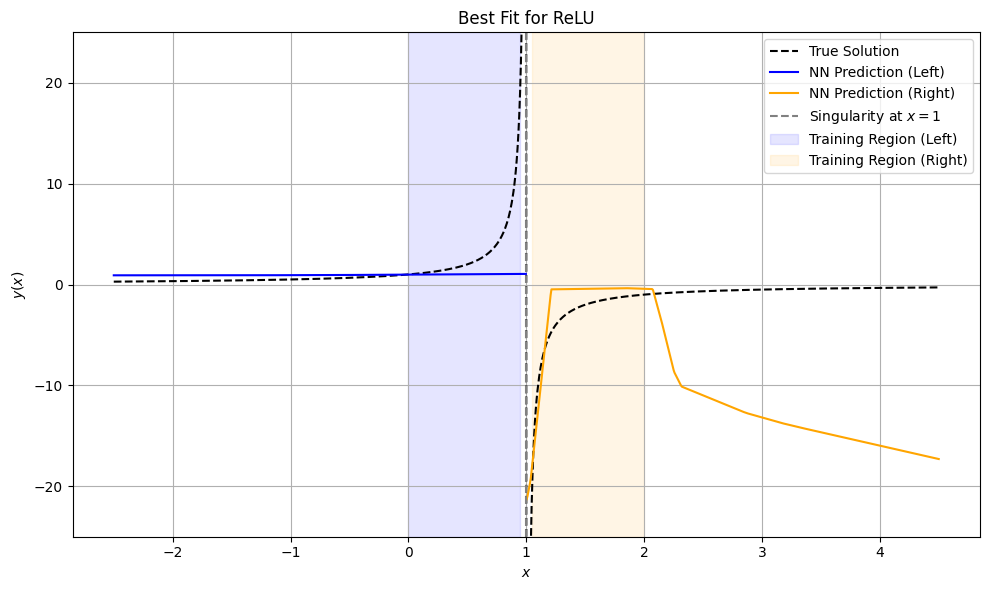

In [124]:
def plot_fit_singularity(config, title, save_prefix="fit_plot"):
    layers = int(config['layers'])
    width = int(config['width'])
    act = config['activation']
    print(f"Plotting {title}: {layers} layers, {width} width, {act} activation")

    # Train left of singularity: x in [0, 0.95], y(0) = 1
    model_left = FeedforwardNN(input_dim=1, output_dim=1,
                               hidden_layers=layers,
                               hidden_units=width,
                               activation=act)
    train_ivp(model_left, y0=1.0, x0=0.0, domain=(0.0, 0.95), epochs=10000, verbose=False)

    # Train right of singularity: x in [1.05, 2.0], y(1.05) = -20
    model_right = FeedforwardNN(input_dim=1, output_dim=1,
                                hidden_layers=layers,
                                hidden_units=width,
                                activation=act)
    train_ivp(model_right, y0=-20.0, x0=1.05, domain=(1.05, 2.0), epochs=10000, verbose=False)

    # Evaluation range (excluding singularity)
    x_test = torch.linspace(-2.5, 4.5, 1000).view(-1, 1)
    x_np = x_test.numpy()
    y_true = 1 / (1 - x_np)

    # Predict left and right
    with torch.no_grad():
        mask_left = x_test[:, 0] < 1
        mask_right = x_test[:, 0] > 1
        y_pred_left = model_left(x_test[mask_left])
        y_pred_right = model_right(x_test[mask_right])

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_np, y_true, "--", label="True Solution", color="black")
    plt.plot(x_np[mask_left], y_pred_left.numpy(), label="NN Prediction (Left)", color="blue")
    plt.plot(x_np[mask_right], y_pred_right.numpy(), label="NN Prediction (Right)", color="orange")
    plt.axvline(x=1.0, linestyle="--", color="gray", label="Singularity at $x=1$")
    plt.axvspan(0.0, 0.95, alpha=0.1, color="blue", label="Training Region (Left)")
    plt.axvspan(1.05, 2.0, alpha=0.1, color="orange", label="Training Region (Right)")

    plt.title(title)
    plt.xlabel("$x$")
    plt.ylabel("$y(x)$")
    plt.ylim([-25, 25])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    filename = f"report/graphics/ivp_singularity_{save_prefix}_{act}_{layers}layers_{width}width.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

plot_fit_singularity(best_configs["tanh"], "Best Fit for Tanh", save_prefix="best_fit")
plot_fit_singularity(best_configs["relu"], "Best Fit for ReLU", save_prefix="best_fit")